In [ ]:
#|default_exp multispectral

In [ ]:
#| export
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Callable
from dataclasses import dataclass
from fastai.vision.all import *

from fastgs.vision.core import *

# High level wrapper classes

> High level API to fastgs functionality

Sentinel 2 images consist of 13 raw bands, with pixel resolution ranging from 10m to 20m to 60m. In practice, we may be working with a subset of these bands.

For example we may choose to only work with the 10m resolution bands IR, R, G, B with corresponding band ids "B08", "B04", "B03", "B02". 

If we create an input tensor of such images the tensor indices of the image data for each band will be 0, 1, 2, 3 (for dimension 0) respectively.

## `BandInputs` support class

To do this we need a helper class that maps channel names to channel indexes.

In [ ]:
#| exports
@dataclass
class BandInputs:
    ids: list[str]
    idxs: list[int]

    @classmethod
    def from_ids(cls, ids: list[str]):
        return cls(ids, [i for i in range(len(ids))])

Map the the channels "B01", "B02", "B03" to 0, 1, 2

In [ ]:
bands = BandInputs.from_ids(["B01","B02","B03"])

test_eq(bands, BandInputs(ids=["B01","B02","B03"], idxs=[0,1,2]))

The following method returns the index corresponding to a channel name

In [ ]:
#| export
@patch
def _get_index(self: BandInputs, id: str) -> int:
    return self.idxs[self.ids.index(id)]

In [ ]:
test_eq(bands._get_index("B02"), 1)

Return index tuples corresponding to a list of channel names.

In [ ]:
#| export
@patch
def _get_bands(self: BandInputs, ids: list[str]) -> tuple[int]:
    assert set(ids).issubset(set(self.ids))
    return tuple(self._get_index(id) for id in ids)

In [ ]:
test_eq(bands._get_bands(["B03","B01"]), (2, 0))

Return list of index tuples corresponding to a list of lists of index channel names.

In [ ]:
#| export
@patch
def get_bands_list(self: BandInputs, ids_list: list[list[str]]) -> list[tuple[int]]:
    return [self._get_bands(ids) for ids in ids_list]

In [ ]:
test_eq(
    bands.get_bands_list([["B03","B02","B01"], ["B01"], ["B03"]]),
    [(2, 1, 0), (0,), (2,)],
)

## `MSDescriptor`

We need a class that can load tensors corresponding to sub-sets of sentinel channels.

In [ ]:
#| export
@dataclass
class MSDescriptor:
    band_ids: list[str]
    res_m: list[int]
    brgtX: list[float]
    rgb_combo: dict[str,list[str]]

We begin an enumeration of the names of all possible channels and associated information. One such item of information, is the resolution corresponding to each channel.

Another piece of information is a list of the `brgtX` "brightening" multipliers for each channel (as described [here](07a_vision.core.ipynb#Image-Brightening)). We have selected values that seem to work well with our data, but it is by no means an authoritative list.

We have also provide some named groups of 3 bands each, that have been found useful in providing [false color images for different applications](https://gisgeography.com/sentinel-2-bands-combinations/). The goal is to create (multiple) RGB images, corresponding to such sets of bands, for each multi-spectral tensor.

In [ ]:
#| export
def createSentinel2Descriptor() -> MSDescriptor:
    return MSDescriptor(
        ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12","AOT"],
        [60,10,10,10,20,20,20,10,20,60,60,20,20,20],
        [2.5,4.75,4.25,3.75,3,2,1.7,1.7,2.5,2.5,1.6,1.6,2.2,30],
        {# https://gisgeography.com/sentinel-2-bands-combinations/
            "natural_color": ["B04","B03","B02"],
            "color_infrared": ["B08","B04","B03"],
            "short_wave_infrared": ["B12","B8a","B04"],
            "agriculture": ["B11","B08","B02"],
            "geology": ["B12","B11","B02"],
            "bathymetric": ["B04","B03","B01"]
        }
    )

In [ ]:
sentinel2 = createSentinel2Descriptor()

This method lists all bands of a given resolution.

In [ ]:
#| export
@patch
def get_res_ids(self: MSDescriptor, res: int) -> list[str]:
    indices = [i for i,r in enumerate(self.res_m) if r == res]
    return [self.band_ids[i] for i in indices]

In [ ]:
test_eq(sentinel2.get_res_ids(10),["B02","B03","B04","B08"])

We can find the brightness multipliers corresponding to a list of channel names with this

In [ ]:
#| export
@patch
def get_brgtX(self: MSDescriptor, ids: list[str]) -> list[float]:
    indices = [self.band_ids.index(id) for id in ids]
    return [self.brgtX[i] for i in indices]

In [ ]:
test_eq(sentinel2.get_brgtX(["B8A","B01"]), [2.5,2.5])
test_eq(sentinel2.get_brgtX(sentinel2.rgb_combo["natural_color"]), [3.75,4.25,4.75])

... and so also the brightness value lists corresponding to name lists

In [ ]:
#| export
@patch
def get_brgtX_list(self: MSDescriptor, ids_list: list[list[str]]) -> list[list[float]]:
    return [self.get_brgtX(ids) for ids in ids_list]

In [ ]:
test_eq(
    sentinel2.get_brgtX_list([sentinel2.rgb_combo["color_infrared"],["B12","B11"]]), 
    [[1.7,3.75,4.25],[2.2,1.6]]
)

## `MSData`

We then create a `MSData` object which takes parameters that specificy how to load the multi spectral image into a `TensorImageMS` object.

In [ ]:
#| export
class MSData:
    pass

In [ ]:
#| export
@patch
def __init__(
    self: MSData,
    ms_descriptor: MSDescriptor,
    band_ids: list[str],
    chn_grp_ids: list[list[str]],
    files_getter: Callable[[list[str], Any], list[str]],
    chan_io_fn: Callable[[list[str]], Tensor]
):
    self.ms_descriptor = ms_descriptor
    self.bands = BandInputs.from_ids(band_ids)
    self.chn_grp_ids = chn_grp_ids
    self.files_getter = files_getter
    self.chan_io_fn = chan_io_fn

In [ ]:
from fastgs.test.io import *

In [ ]:
def get_input(stem: str) -> str:
    "Get full input path for stem"
    return "./images/" + stem

def tile_img_name(chn_id: str, tile_num: int) -> str:
    "File name from channel id and tile number"
    return f"Sentinel20m-{chn_id}-20200215-{tile_num:03d}.png"

def get_channel_filenames(chn_ids, tile_idx):
    "Get list of all channel filenames for one tile idx"
    return [get_input(tile_img_name(x, tile_idx)) for x in chn_ids]

seg_codes = ["not-cloudy","cloudt"] 

We can create a sentinel data loader for only the RGB channels

In [ ]:
rgb_bands = MSData(
    sentinel2,
    ["B02","B03","B04"],
    [sentinel2.rgb_combo["natural_color"]],
    get_channel_filenames,
    read_multichan_files
)

where `read_multichan_files_as_tensor` is defined [here](00_vision.io.ipynb)

or we might choose to only look at the 10m resolution bands 

In [ ]:
tenm_bands = MSData(
    sentinel2,
    sentinel2.get_res_ids(10),
    [sentinel2.rgb_combo["natural_color"], ["B08"]],
    get_channel_filenames,
    read_multichan_files
)

or even 11 channels of sentinel 2 data

In [ ]:
elvn_bands = MSData(
    sentinel2,
    ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12","AOT"],
    [sentinel2.rgb_combo["natural_color"], ["B07","B06","B05"],["B12","B11","B8A"],["B08"]],
    get_channel_filenames,
    read_multichan_files
)

In [ ]:
#| export
@patch
def _load_image(self: MSData, img_id, cls: TensorImage) -> TensorImage:
    files = self.files_getter(self.bands.ids, img_id)
    ids_list = self.chn_grp_ids
    bands = self.bands.get_bands_list(ids_list)
    brgtX = self.ms_descriptor.get_brgtX_list(ids_list)
    return cls(self.chan_io_fn(files), bands=bands, brgtX=brgtX)

@patch
def load_image(self: MSData, img_id) -> TensorImageMS:
    return self._load_image(img_id, TensorImageMS)                

In [ ]:
#| export
@patch
def num_channels(self: MSData) -> int:
    return len(self.bands.ids)

[<AxesSubplot:>]

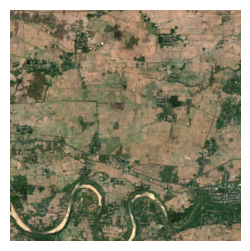

In [ ]:
rgb_tensor = rgb_bands.load_image(66)
test_eq(rgb_bands.num_channels(),3)
rgb_tensor.show()

[<AxesSubplot:>, <AxesSubplot:>]

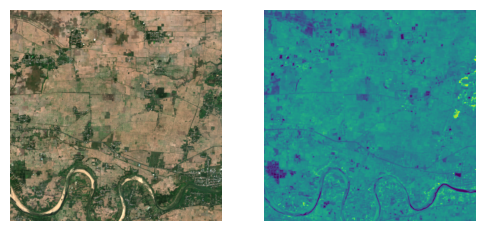

In [ ]:
tenm_tensor = tenm_bands.load_image(66)
test_eq(tenm_bands.num_channels(),4)
tenm_tensor.show()

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

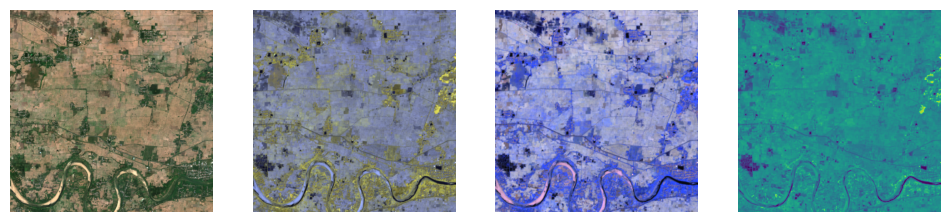

In [ ]:
elvn_tensor = elvn_bands.load_image(66)
test_eq(elvn_bands.num_channels(),11)
elvn_tensor.show()

## `MaskData`

Finally, for convenience, we provide a class to load mask data

In [ ]:
#| export
class MaskData:
    pass

In [ ]:
#| export
@patch
def __init__(
    self: MaskData,
    mask_id: str,
    files_getter: Callable[[list[str], Any], list[str]],
    mask_io_fn: Callable[[list[str]], TensorMask],
    mask_codes: list[str]
):
    self.mask_id = mask_id
    self.files_getter = files_getter
    self.mask_io_fn = mask_io_fn
    self.mask_codes = mask_codes

In [ ]:
#| export
@patch
def load_mask(self: MaskData, img_id) -> TensorMask:
    file = self.files_getter([self.mask_id], img_id)[0]
    return self.mask_io_fn(file)

In [ ]:
#| export
@patch
def num_channels(self: MaskData) -> int:
    return len(self.mask_codes)

<AxesSubplot:>

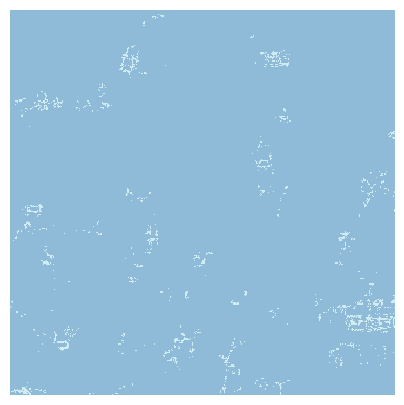

In [ ]:
masks = MaskData("LC",get_channel_filenames,read_mask_file,["non-building","building"])
test_eq(masks.num_channels(),2)
mask = masks.load_mask(66)
mask.show()

## Data loaders

Next we create the block transforms for images and masks

In [ ]:
#| export
@patch
def create_xform_block(self: MSData) -> DataBlock:
    return TransformBlock(
        type_tfms=[
            partial(MSData.load_image, self),
        ]
    )

In [ ]:
#| export
@patch
def create_xform_block(self: MaskData) -> DataBlock:
    return TransformBlock(
        type_tfms=[
            partial(MaskData.load_mask, self),
            AddMaskCodes(codes=self.mask_codes),
        ]
    )

## Multi spectral pipeline

In [ ]:
#| export
class MSPipeline:
    pass

In [ ]:
#| export
@patch
def __init__(self: MSPipeline, ms_data: MSData, mask_data: MaskData):
    self.ms_data = ms_data
    self.mask_data = mask_data

In [ ]:
#| export
@patch
def create_data_block(self: MSPipeline, splitter=RandomSplitter(valid_pct=0.2, seed=107)) -> DataBlock:
    return DataBlock(
        blocks=(self.ms_data.create_xform_block(), self.mask_data.create_xform_block()),
        splitter=splitter
    )

Next we create the `unet_learner`. If we use a pretrained model, the weights are only set for the first 3 channels. The remaining channels are set to an average of the weights across the 3 pretrained channels. The weights are then normalized to adjust for the increased number of channels.

In [ ]:
#| export
@patch
def create_unet_learner(self: MSPipeline,dl,model,pretrained=True,loss_func=CrossEntropyLossFlat(axis=1),metrics=Dice(axis=1)) -> Learner:
    learner = unet_learner(
        dl,model,normalize=False,n_in=len(self.ms_data.bands.ids),n_out=len(self.mask_data.mask_codes),
        pretrained=pretrained, loss_func=loss_func,metrics=metrics
    )
    if pretrained:
        layer_1 = learner.model[0][0]
        w = layer_1.weight
        w_mean = torch.mean(w[:,:3,:,:],1,True)
        w[:,3:,:,:] = w_mean
        w = w * (3.0 / w.shape[1])
    return learner

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()